In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load inflow dataset into dataframe
inflow_data = pd.read_excel("InflowData_1.xlsx")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# define start and end dates for analysis
start = '2022-07-03'
end = '2022-07-24'

# weather data
weather_data = pd.read_excel("WeatherData_1.xlsx")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index, format="%d/%m/%Y %H:%M")

# reduce time series to specified start and end dates
tseriesX_df = weather_data[start:end].copy()

# fill missing values with interpolation technique
tseriesX_df.interpolate(limit_direction='both',inplace=True)

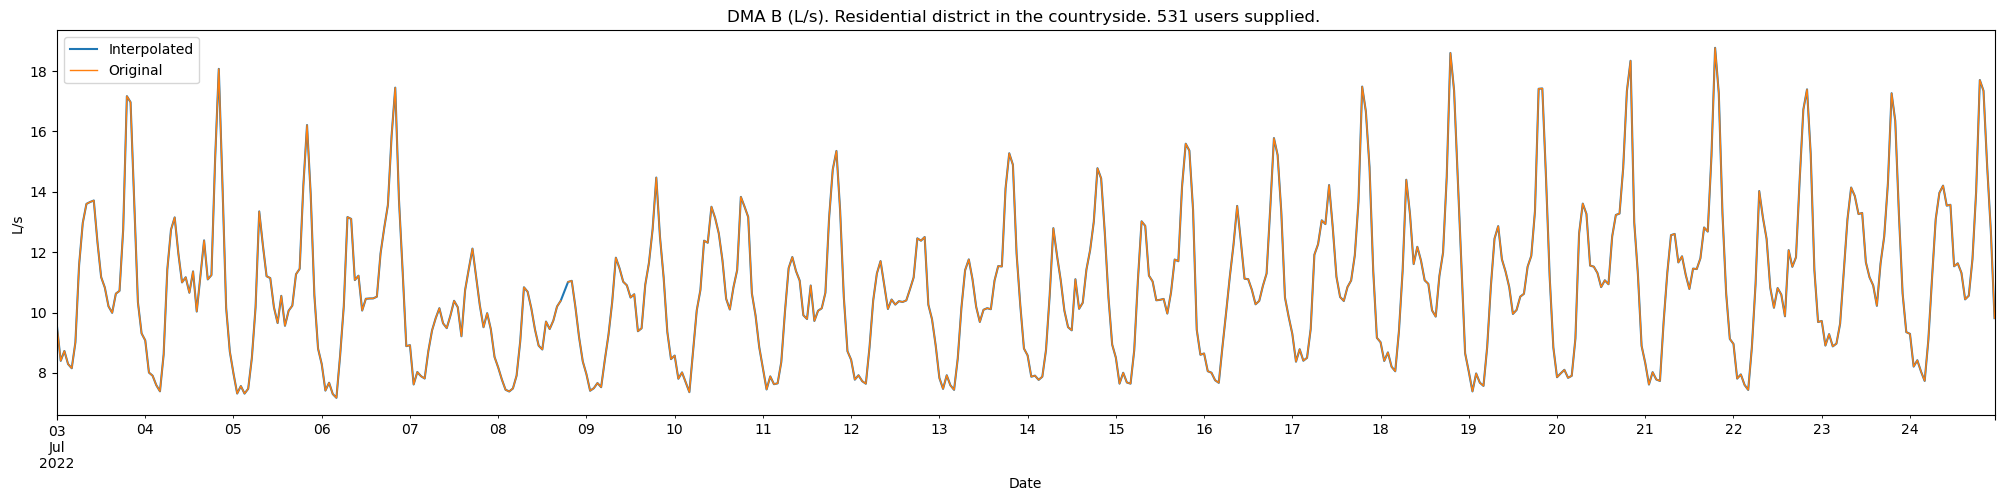

In [2]:
# select dma for analysis
dma = 'DMA B (L/s)'

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# copy data from dataframe in a new time series dataframe
tseries = inflow_data[dma][start:end].copy()

# fill missing values with interpolation technique
tseries.interpolate(limit_direction='both',inplace=True)

# plot original and interpolated time series for selected dma
fig, ax = plt.subplots()
tseries.plot(label='Interpolated')
inflow_data[dma][start:end].plot(y=dma_list,use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
plt.xlabel("Date")
plt.ylabel("L/s")
plt.legend()
plt.show()

In [3]:
# imports for time series analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *

First check data is stationary

In [4]:
# use the augmented dicker-fuller test to test if data is stationary.
result = adfuller(tseries)
# print('ADF Statistic: %f' % result[0])
# print p-value, if p-value < threshold usually 0.05 then data stationary
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

p-value: 0.000300


Check Autocorrelation and partial autocorrelation plots

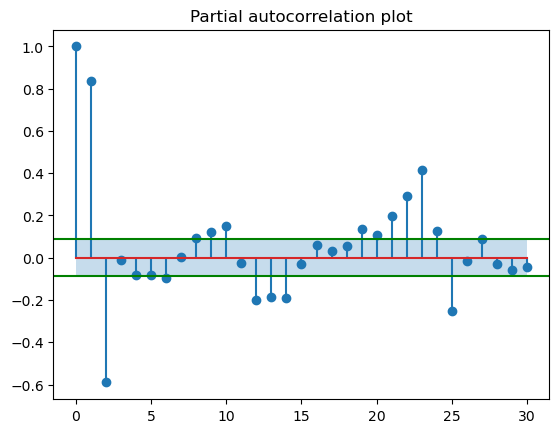

In [5]:
L = len(tseries)

pacf_values = sm.tsa.pacf(tseries, nlags=30, method='ywm') # diff_2 or res2.resid

plt.stem(np.arange(0,31),pacf_values)
plt.axhline(2*1/np.sqrt(L),0,1,c='g')
plt.axhline(-2*1/np.sqrt(L),0,1,c='g')
plt.fill_between(np.arange(0,31),2*1/np.sqrt(L),-2*1/np.sqrt(L),alpha=0.25)
plt.title('Partial autocorrelation plot')
plt.show()

In [6]:
potential_p = np.where(np.abs(pacf_values) > 3*1/np.sqrt(L))[0]
potential_p

array([ 0,  1,  2, 10, 12, 13, 14, 19, 21, 22, 23, 25])

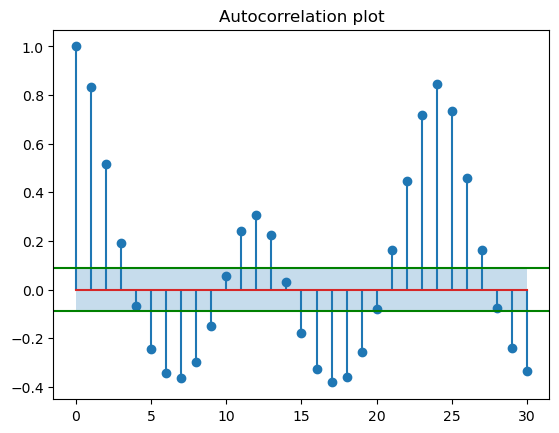

In [7]:
acf_values = sm.tsa.acf(tseries, nlags=30) # diff_2 or res2.resid

plt.stem(np.arange(0,31),acf_values)
plt.axhline(2*1/np.sqrt(L),0,1,c='g')
plt.axhline(-2*1/np.sqrt(L),0,1,c='g')
plt.fill_between(np.arange(0,31),2*1/np.sqrt(L),-2*1/np.sqrt(L),alpha=0.25)
plt.title('Autocorrelation plot')
plt.show()

In [8]:
potential_q = np.where(np.abs(acf_values) > 3*1/np.sqrt(L))[0]
potential_q

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19,
       21, 22, 23, 24, 25, 26, 27, 29, 30])

In [9]:
# train and test datasets
tseries_train, tseries_test = temporal_train_test_split(tseries, test_size = 168)

# X = tseriesX_df
# X_train, X_test = temporal_train_test_split(X, test_size=168)

### AR part

A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’. 

$Y_t = \alpha + \beta_1 Y_{t-1} + \dots + \beta_p Y_{t-p} + e_1$

where, $Y_{t-1}$ is the lag 1 of the series, $\beta_1$ is the coefficient of the lag 1 that the model estimates, and $\alpha$ is the intercept term, also estimated by the model. 

Given that there are p past values, this is denoted as AR(p) or an autoregressive model of the order p. $e_1$ indicates the white noise 

In [10]:
# create arima model
class ARIMA():
    # def __init__(self):

    def fit_AR(tseries,p):
        # copy dataframe to make a new one with lagged values as features
        df_lags = tseries.copy().to_frame()

        # make dataframe with lagged values
        for i in range(1,p+1): # +1 is added because we start from 1.
            df_lags['lag'+str(i)] = df_lags.iloc[:,0].shift(i)

        # make the target train vector y
        y_train = df_lags.iloc[p:,0].values.reshape(-1,1)

        # make the feature train/design matrix X
        X_train = df_lags.iloc[p:,1:].values

        # add intercept term
        X_train = np.column_stack((np.ones_like(y_train),X_train))
        
        ## do linear regression to obtain coefficients of lagged terms
        ## in this case we use the normal equations
        # solve the linear regression problem using the normal equations
        theta = np.linalg.inv( (X_train.transpose() @ X_train) ) @ X_train.transpose() @ y_train

        # make a class for the fitted model
        class model_fit():
            def __init__(self):
                # super().__init__(ARIMA) # when inheriting properties from another class
                
                # initialize parameters and variables
                self.theta = theta
                self.p = p
                self.X_train = X_train
                self.y_train = y_train
                self.tseries = tseries
            
            def predict_train(self):
                y_train_fitted = self.X_train @ self.theta

                return y_train_fitted
            
            def forecast(self,forecast_length=12):
                # forecast one step at a time, and using prediction result to forecast next time step (errors accumulate)

                # convert time series to dataframe
                df_lags = tseries.to_frame()

                # extend index of dataframe forecast_length periods
                new_index = df_lags.index.append(pd.date_range(start=df_lags.index[-1] + pd.Timedelta(1,df_lags.index.inferred_freq), periods=forecast_length, freq=df_lags.index.inferred_freq))

                # reindex dataframe to extend p periods
                df_lags = tseries.reindex(new_index).to_frame()

                # make dataframe with lagged values
                for i in range(1,self.p+1): # +1 is added because we start from 1.
                    df_lags['lag'+str(i)] = df_lags.iloc[:,0].shift(i)

                # reduce dataframe
                df_lags = df_lags.iloc[-forecast_length:,:]

                # get values for the range of the lagged values, fills the diagonal
                for i in range(self.p):
                    period = forecast_length - i
                    X = np.vstack(([1],df_lags.iloc[-period,1:].values.reshape(-1,1))) # n+1 x 1 vector

                    # first prediction    
                    df_lags.iloc[-period,0] = self.theta.transpose() @ X

                    for j in range(1,i+2):
                    # lag j value for next forecast
                        df_lags.iloc[-period+1,j] = df_lags.iloc[-period,j-1]


                # continue forecast after the first p forecasted values
                for t in range(forecast_length - self.p ,1,-1):
                    # make vector of feature lags
                    X = np.vstack(([1],df_lags.iloc[-t,1:].values.reshape(-1,1))) # n+1 x 1 vector

                    # make forecast at time t
                    df_lags.iloc[-t,0] = self.theta.transpose() @ X

                    for n in range(self.p,0,-1):
                        df_lags.iloc[-t+1,n] = df_lags.iloc[-t,n-1]

                # make the last forecast

                X = np.vstack(([1],df_lags.iloc[-1,1:].values.reshape(-1,1))) # n+1 x 1 vector
                df_lags.iloc[-1,0] = self.theta.transpose() @ X

                return df_lags.iloc[:,0]

        return model_fit()

In [11]:
# fit model only AR part
p = 4
model_fit = ARIMA.fit_AR(tseries_train,p)

# calculate fitted values
y_train_fitted = model_fit.predict_train()

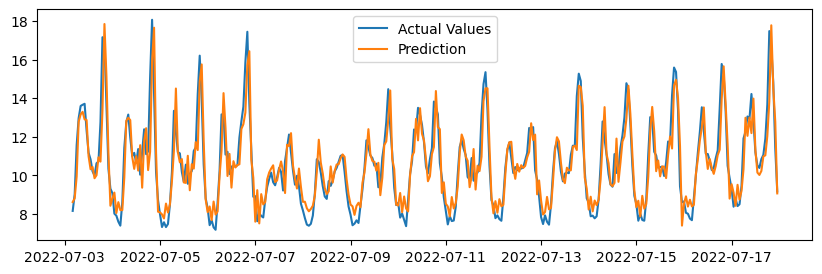

In [12]:
fig, ax = plt.subplots(figsize = (10,3))
plt.plot(tseries_train.index.values[p:],model_fit.y_train)
plt.plot(tseries_train.index.values[p:],y_train_fitted)
ax.legend(['Actual Values', 'Prediction'])
plt.show()

In [13]:
y_test_forecasted = model_fit.forecast(forecast_length=168)

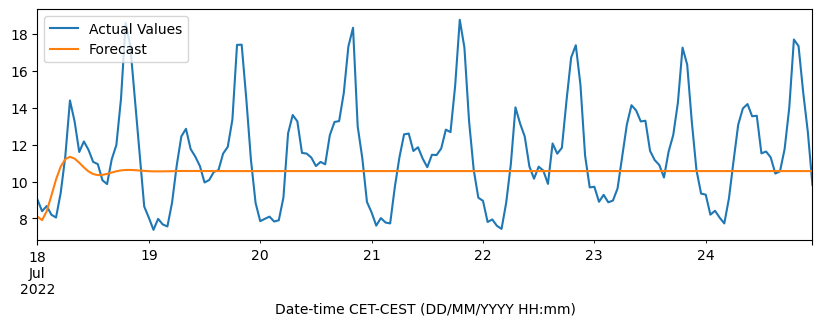

In [14]:
fig, ax = plt.subplots(figsize = (10,3))
tseries_test.plot(ax=ax)
y_test_forecasted.plot(ax=ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()